In [1]:
import torch
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm import tqdm
import h5py

from spherex_emu.emulator import pk_emulator
from spherex_emu.dataset import pk_galaxy_dataset
from spherex_emu.utils import load_config_file, calc_avg_loss, normalize

In [2]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 11})
plt.rcParams["legend.frameon"] = False

In [3]:
def make_heatmap(x, y, z, bins, median=True):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.linspace(np.amin(y), np.amax(y), bins+1)
    z_new = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            if median == True: z_new[j,i] = np.median(z[(x >= x_new[i]) & (x < x_new[i+1]) & (y >= y_new[j]) & (y < y_new[j+1])])
            else: z_new[j,i] = np.mean(z[(x >= x_new[i]) & (x < x_new[i+1]) & (y >= y_new[j]) & (y < y_new[j+1])])
    
    return x_new, y_new, z_new

def make_diagonal(x, y, bins, median=True):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.zeros(bins)
    for i in range(bins):
        if median == True: y_new[i] = np.median(y[(x >= x_new[i]) & (x <= x_new[i+1])])
        else: y_new[i] = np.mean(y[(x >= x_new[i]) & (x <= x_new[i+1])])
    return x_new[:bins], y_new

def plot_heatmap(params, data, label, extents, cmap, log_scale, median=False):
    names = ["As", "fnl", 'h', 'omega_c', "b1", "bphi"]
    labels= [r"$A_s$", r"$f_{nl}$", r"$h$", r'$\omega_{cdm}$', "$b_1$", "$b_{\phi}$", label]
        
    params = params.copy()
    fig, axs = plt.subplots(len(names),len(names), figsize=(12,12), sharex="col")
    for i in range(len(names)):
        for j in range(len(names)):
            if i < j:
                axs[i][j].axis("off")
                continue
            if i == j:
                x, y = make_diagonal(params[:,j], data, 25, median)
                axs[i][j].plot(x, y)
            else:
                X, Y, Z = make_heatmap(params[:,j], params[:,i], data, 25, median)
                if log_scale == True: img = axs[i,j].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]), cmap=cmap, 
                                                      norm=colors.LogNorm(vmin=extents[0], vmax=extents[1]))
                else: img = axs[i,j].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]), cmap=cmap, vmin=extents[0], vmax=extents[1])
                axs[i,j].set_xlim(X[0] - (X[-1] - X[0]) * 0.05, X[-1] + (X[-1] - X[0]) * 0.05)
                axs[i,j].set_ylim(Y[0] - (Y[-1] - Y[0]) * 0.05, Y[-1] + (Y[-1] - Y[0]) * 0.05)
                
                axs[i,j].xaxis.set_ticks_position('both')
                axs[i,j].yaxis.set_ticks_position('both')
            
            axs[i,j].tick_params(direction="in")
            for item in ([axs[i,j].xaxis.label, axs[i,j].yaxis.label]):
                item.set_fontsize(15)
                    
            #if i != j: axs[i][j].axhline(params_best[i], linestyle="--", c="black")
            #axs[i][j].axvline(params_best[j], linestyle="--", c="black")
            if i == 5: axs[i][j].set_xlabel(labels[j])
            if j == 0 and i != 0: axs[i][j].set_ylabel(labels[i])
            #if j == 0 and i != 5:   axs[i][j].xaxis.set_ticklabels([])
            elif j != 0 and i == 5: axs[i][j].yaxis.set_ticklabels([])
            elif j != 0 and i != 5:
                #axs[i][j].xaxis.set_ticklabels([])
                axs[i][j].yaxis.set_ticklabels([])

    #axs[5][3].set_xticks([1,2,3,4])
    cbar_ax = fig.add_axes([0.96, 0.14, 0.039, 0.7])
    cbar = fig.colorbar(img, cax=cbar_ax)
    cbar.set_label(labels[-1], size=22)
    cbar.ax.tick_params(labelsize=18) 
    plt.subplots_adjust(wspace=0, hspace=0, right=0.95)
    
    #plt.savefig("../CovNet/Plots/chi2-error.pdf", dpi=300, bbox_inches='tight')

In [4]:
# invcov_raw = np.load(cov_dir+"invcov.npy")

# model_vector = np.random.uniform(size=(1,1,2,25))
# nz, nps, nk, nl = 1, 1, 25, 2
# invcov = invcov_raw.reshape(nz, nk*nps*nl, nk*nps*nl)

# delta = data_vector - model_vector
# delta = np.transpose(delta, (0,1,3,2))
# delta = np.transpose(delta, (1,0,2,3)) # (nps, nz, nk, nl) -> (nz, nps, nk, nl)
# delta = delta.reshape((nz, nps*nk*nl)) # (nz, nps, nk, nl) --> (nz, nps*nk*nl) 

# delta_row = delta[:, np.newaxis, :,] # (nz, 1, nps*nk*nl) 
# delta_col = delta[:, :, np.newaxis,] # (nz, nps*nk*nl, 1) 

# chi2_component = np.matmul(delta_row, np.matmul(invcov_raw, delta_col))[..., 0, 0] # invcov is (nz, nps*nk*nl, nps*nk*nl)
# chi2 = np.sum(chi2_component)

In [5]:
# load the network
emulator_dir = "/home/joeadamo/Research/SPHEREx/spherex_emu/emulators/mlp_multi_redshift/"
#config_file = "/home/joeadamo/Research/SPHEREx/spherex_emu/configs/network_pars_single_tracer_single_redshift.yaml"
config_dict = load_config_file(emulator_dir+"config.yaml")
k = np.linspace(0.01, 0.25, 25)

emulator = pk_emulator(emulator_dir+"config.yaml")
emulator.load_trained_model()

In [6]:
# load the test dataset
#print(emulator.output_normalizations)
test_data = emulator._load_data("testing", 1., False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=config_dict["batch_size"], shuffle=True)

### code for calculating chi squared  

NOTE: Eventually this will need to be upgraded to handle multi-tracer, possibly by implimenting what is done in Cosmo_Inferene

In [7]:
# #cov_dir = "/home/joeadamo/Research/SPHEREx/spherex_emu/Cosmo_Inference_covariances/"
# cov_dir = "/home/joeadamo/Research/SPHEREx/Cosmo_Inference/pipeline/sample_outputs/lss_theory/spherex_emu_1s_2z/"
# invcov_raw = np.load(cov_dir+"invcov.npy")
# #print(invcov.shape) #<- nz, nk, nps*nl, nps*nl

# invcov = np.zeros((emulator.num_zbins, 50, 50))
# for z in range(invcov_raw.shape[0]):
#     for i in range(invcov_raw.shape[1]):
#         invcov[z, i,i] = invcov_raw[z,i,0,0]
#         invcov[z, i+25,i+25] = invcov_raw[z,i,1,1]
#         invcov[z, i,i+25] = invcov_raw[z,i,0,1]
#         invcov[z, i+25,i] = invcov_raw[z,i,1,0]

# data_vector = np.load(cov_dir+"data_vec_fid.npy")
# data_vector = data_vector.flatten()
# # data_vector = h5py.File(cov_dir+'As_ns_fnl_ombh2_omch2_nrun_*b10/redshift_bins_1_samples_1.hdf5', 'r')
# # print(data_vector.keys())
# # print(data_vector["dmu"])

# def chi_squared(model_vector):

#     model_vector = model_vector.flatten()
#     x = data_vector - model_vector
#     chi2 = np.matmul(x.T, np.matmul(invcov, x))
#     return chi2

# C = np.zeros((25, 25))
# np.fill_diagonal(C, np.concatenate((C_compressed[0,:,0,0], C_compressed[0,:,1,1])))
# print(C.shape)

# plt.imshow(C)
# # plt.plot(C[0,:,0,0])
# # #plt.plot(C[0,:,1,0])
# # #plt.plot(C[0,:,0,1])

Best training loss   = 0.0474
Best validation loss = 0.0464
Average test loss    = 0.0424


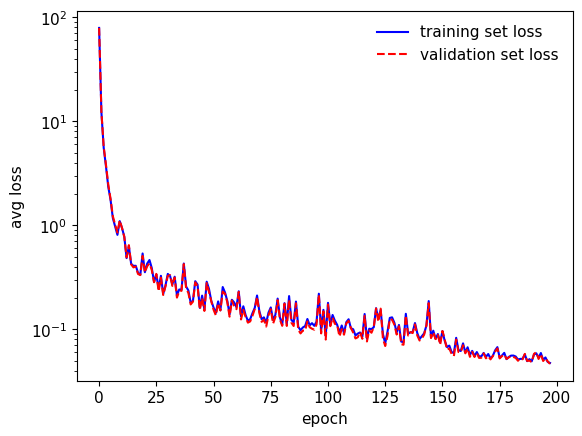

In [8]:
training_data = torch.load(emulator_dir+"train_data.dat")

epochs = range(training_data.shape[1])
train_loss = training_data[0,:]
valid_loss = training_data[1,:]
test_loss = calc_avg_loss(emulator.model, test_loader)

print("Best training loss   = {:0.4f}".format(torch.amin(train_loss)))
print("Best validation loss = {:0.4f}".format(torch.amin(valid_loss)))
print("Average test loss    = {:0.4f}".format(test_loss))

plt.plot(epochs, train_loss, c="blue", label="training set loss")
plt.plot(epochs, valid_loss, c="red", ls="--", label="validation set loss")
plt.xlabel("epoch")
plt.ylabel("avg loss")
plt.yscale("log")
plt.legend()

In [9]:
# pk_true = np.zeros((len(test_data), 1, 1, 2, 25))
# pk_emu = np.zeros((len(test_data), 1, 1, 2, 25))
# params_neg = []
# idx_neg = []
# for i in tqdm(range(len(test_data))):
#     params = test_data[i][0].detach().numpy()
#     pk_true[i] = test_data.get_power_spectra(i)
#     pk_emu[i] = emulator.get_power_spectra(params)
#     if np.any(pk_true[i,0,0,0,:] < 0):
#         params_neg.append(test_data[i][0].detach().numpy())
#         idx_neg.append(i)
# params_neg = np.array(params_neg)

# fig, ax = plt.subplots(1, 2, figsize=(9,5))
# for i in range(len(test_data)):
#     ax[0].plot(k, pk_true[i,0,0,0,:], c="red", lw=0.1, alpha=0.2)
#     ax[1].plot(k, pk_true[i,0,0,1,:], c="red", lw=0.1, alpha=0.2)

# print(np.amax(pk_true), np.amin(pk_true))

# ax[0].axhline(0, c="black", ls="--")
# ax[1].axhline(0, c="black", ls="--")

# ax[0].set_xlabel("k")
# ax[1].set_xlabel("k")
# #plt.ylim(-10000, 0)

In [10]:
pk_error = []
error_per_bin = np.zeros((2, 25))
chi2_error = np.zeros(len(test_data))
chi2 = np.zeros(len(test_data))

for i in tqdm(range(len(test_data))):

    #params = test_data[i][0].detach().numpy()
    params = test_data.get_repeat_params(i, emulator.num_zbins, emulator.num_samples)
    pk_true = test_data.get_power_spectra(i)
    pk_pred = emulator.get_power_spectra(params)

    # chi2_pred = chi_squared(pk_pred)
    # chi2_true = chi_squared(pk_true)
    # chi2_error[i] = (chi2_pred - chi2_true) / chi2_true
    # chi2[i] = chi2_true
    
    #pk_true = normalize(pk_true, config_dict["min_norm_v"], config_dict["max_norm_v"])
    #pk_pred = normalize(pk_pred, config_dict["min_norm_v"], config_dict["max_norm_v"])
    #if np.any(pk_true < 0) == False:
    pk_error.append((pk_pred - pk_true) / pk_true)

pk_error = np.array(pk_error)
print(pk_error.shape)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2371.97it/s]

(1000, 2, 1, 2, 25)


In [ ]:
print("mean chi2 error = {:0.2f}%".format(100*np.mean((abs(chi2_error)))))

print(np.amin(chi2), np.amax(chi2))

cmap="RdBu"
#extents = [2e6, 1e10]
extents = [-0.15, 0.15]
#plt.hist(chi2_error, bins=40)
plot_heatmap(test_data.params.detach().numpy(), chi2_error, r"$\frac{|\chi^2_{emulator} - \chi^2_{true}|}{\chi^2_{true}}$", extents, cmap, False, median=False)

18.887850642204285
Average errror per bin = 27.18% +- 2262.07%
Average error per bin per multipole = [18.89%%, 53.49%]
Median errror per bin = 2.71%
Median error per bin per multipole = [2.67%%, 3.32%]


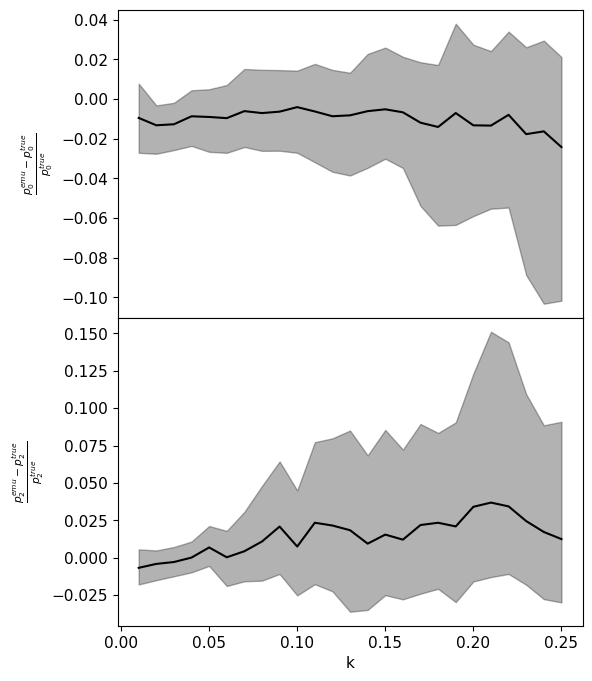

In [11]:
error_mean = np.mean(pk_error, axis=0)[0,0,:,:]
error_std = np.std(pk_error, axis=0)[0,0,:,:]
error_median = np.median(pk_error, axis=0)[0,0,:,:]
error_perc = np.percentile(pk_error, (25, 75), axis=0)[:,0,0,:,:]

print(100*np.mean(np.mean(abs(pk_error), axis=4), axis=0)[0,0,0])

print("Average errror per bin = {:0.2f}% +- {:0.2f}%".format(100*np.mean(abs(pk_error)), 100*np.std(abs(pk_error))))
print("Average error per bin per multipole = [{:0.2f}%%, {:0.2f}%]".format(100*np.mean(np.mean(abs(pk_error), axis=4), axis=0)[0,0,0],
                                                                           100*np.mean(np.mean(abs(pk_error), axis=4), axis=0)[0,0,1]))
print("Median errror per bin = {:0.2f}%".format(100*np.median(abs(pk_error))))
print("Median error per bin per multipole = [{:0.2f}%%, {:0.2f}%]".format(100*np.median(abs(pk_error), axis=[0, 4])[0,0,0],
                                                                          100*np.median(abs(pk_error), axis=[0, 4])[0,0,1]))
fig, ax = plt.subplots(2, 1, figsize=(6,8), sharex=True)
# for i in range(0, len(pk_error), 2):
#    ax[0].plot(k, pk_error[i,0,0,0,:], c="red", lw=0.1, alpha=0.1)
#    ax[1].plot(k, pk_error[i,0,0,1,:], c="red", lw=0.1, alpha=0.1)
# ax[0].plot(k, error_mean[0,:], c="black")
# ax[1].plot(k, error_mean[1,:], c="black")
# ax[0].fill_between(k, error_mean[0,:] - error_std[0,:], error_mean[0,:] + error_std[0,:],
#                    color="black", alpha=0.3)
# ax[1].fill_between(k, error_mean[1,:] - error_std[1,:], error_mean[1,:] + error_std[1,:],
#                    color="black", alpha=0.3)
ax[0].plot(k, error_median[0,:], c="black")
ax[1].plot(k, error_median[1,:], c="black")
ax[0].fill_between(k, error_perc[0,0,:], error_perc[1,0,:], color="black", alpha=0.3)
ax[1].fill_between(k, error_perc[0,1,:], error_perc[1,1,:], color="black", alpha=0.3)

# ax[0].plot(k, error_mean[0,0,0,:], c="black")
# ax[1].plot(k, error_mean[0,0,1,:], c="black")
ax[1].set_xlabel("k")
ax[0].set_ylabel(r"$\frac{p_0^{emu} - p_0^{true}}{p_0^{true}}$")
ax[1].set_ylabel(r"$\frac{p_2^{emu} - p_2^{true}}{p_2^{true}}$")
# ax[0].set_ylim(-.2, .2)
# ax[1].set_ylim(-.2, .2)
fig.subplots_adjust(hspace=0)

In [ ]:
# pk_CLASS_PT = np.array([16820.05513766, 23946.48158473, 25453.02712092, 24037.92768727,
#                         21593.59444023, 19017.53002514, 16536.15764868, 14148.70189409,
#                         11847.34712271,  9675.37480162,  7698.56909414,  5957.1104404,
#                         4450.72807379,  3157.2194757,   2057.24458963,  1129.07015037,
#                         336.55155207,  -354.79329047,  -973.23837262, -1530.23765555,
#                        -2011.6919702,  -2406.67233749, -2721.42923145, -2966.09015841, -3155.87940414])

# pk_yosuke = test_data.get_power_spectra(idx_neg[0])

# plt.plot(k, pk_CLASS_PT)
# plt.plot(k, pk_yosuke[0,0,0,:])

## Test individual power spectra

997
tensor([[[[ 1.4240e-09, -3.0530e+01,  7.4989e-01,  1.7846e-01,  3.7961e+00]],

         [[ 1.4240e-09, -3.0530e+01,  7.4989e-01,  1.7846e-01,  3.7961e+00]]]])
Raw loss = 2.728e-02, true loss = 1.829e+10
Average error per bin = 25.13%
torch.Size([2, 1, 2, 25])


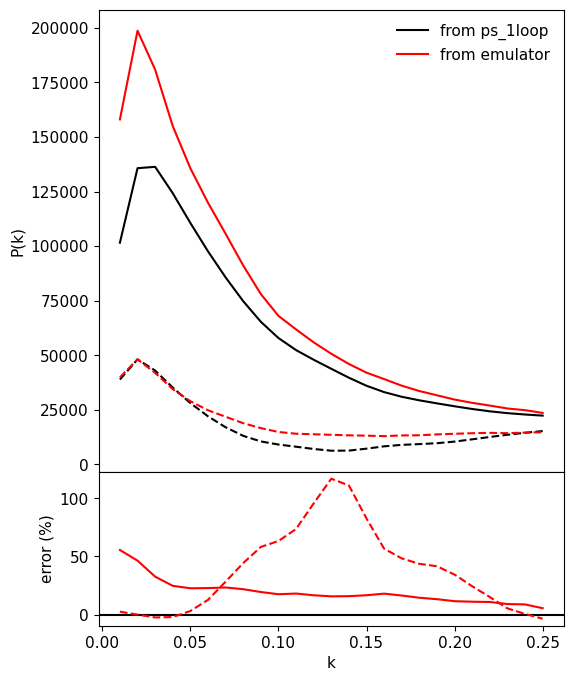

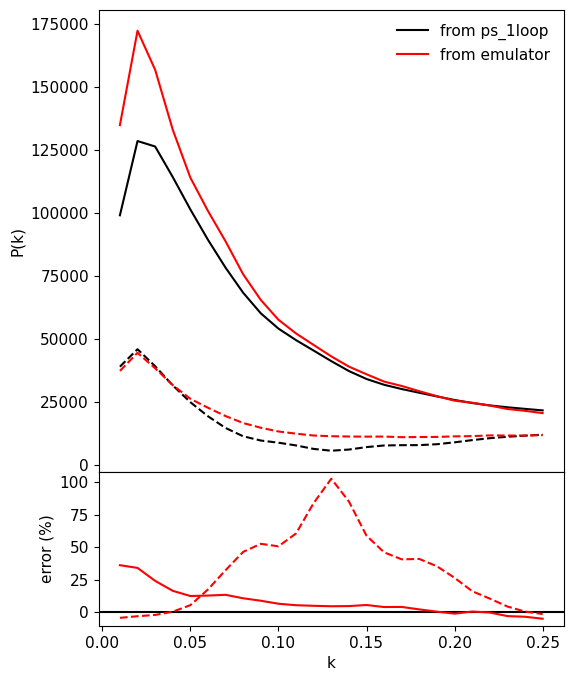

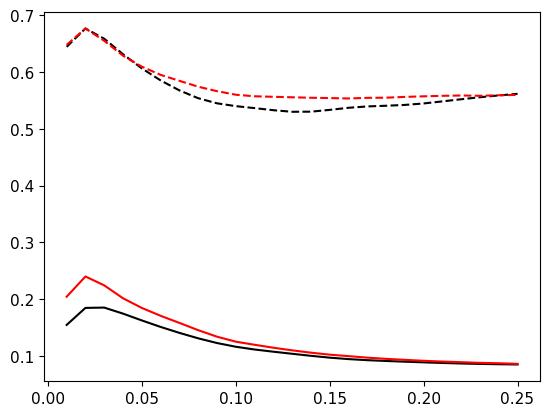

In [28]:
idx = np.random.randint(len(test_data))
idx = 997
print(idx)

pk_true = test_data.get_power_spectra(idx)
#params = test_data[idx][0]
params = test_data.get_repeat_params(i, emulator.num_zbins, emulator.num_samples)
print(params)

pk_emu = emulator.get_power_spectra(params.detach().numpy())
error = 100 * (pk_emu - pk_true) / pk_true
loss = F.mse_loss(torch.from_numpy(pk_true), torch.from_numpy(pk_emu), reduction="sum")
# chi2_emu = chi_squared(pk_emu)
# chi2_true = chi_squared(pk_true)

pk_raw = test_data[idx][1].view(emulator.num_zbins, 1, 2, len(k)).detach()
pk_emu_raw = emulator.model.forward(params)
pk_emu_raw = pk_emu_raw.view(emulator.num_zbins, 1, 2, len(k)).detach()
raw_loss = F.mse_loss(pk_emu_raw.flatten(), pk_raw.flatten(), reduction="sum")

print("Raw loss = {:0.3e}, true loss = {:0.3e}".format(raw_loss, loss))
print("Average error per bin = {:0.2f}%".format(np.mean(abs(error))))
#print("Difference in chi2 = {:0.2f}%".format(100*(chi2_pred - chi2_true) / chi2_true))
print(pk_emu_raw.shape)

for z in range(emulator.num_zbins):
    fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    axs[0].plot(k, pk_true[z,0,0,:], c="black", label="from ps_1loop")
    axs[0].plot(k, pk_emu[z,0,0,:], c="red", label="from emulator")
    #axs[0].plot(k, data_vector[:25], c="blue", label="data vector")
    axs[0].plot(k, pk_true[z,0,1,:], c="black", ls="--")
    axs[0].plot(k, pk_emu[z,0,1,:], c="red", ls="--")
    #axs[0].plot(k, data_vector[25:], c="blue", ls="--")
    axs[1].axhline(0, c="black")
    axs[1].plot(k, error[z,0,0,:], c="red")
    axs[1].plot(k, error[z,0,1,:], c="red", ls="--")
    
    axs[1].set_xlabel("k")
    axs[0].set_ylabel("P(k)")
    axs[1].set_ylabel("error (%)")
    axs[0].legend()
    fig.subplots_adjust(hspace=0)

plt.figure()
plt.plot(k, pk_raw[0,0,0,:], c="black", label="from ps_1loop")
#plt.plot(k, pk_raw[1,0,0,:], c="black", label="from ps_1loop")
plt.plot(k, pk_emu_raw[0,0,0,:], c="red", label="from emulator")
plt.plot(k, pk_raw[0,0,1,:], c="black", ls="--")
#plt.plot(k, pk_raw[1,0,1,:], c="black", ls="--")
plt.plot(k, pk_emu_raw[0,0,1,:], c="red", ls="--")

## Display results form running optimize_parameters.py

In [ ]:
from matplotlib.ticker import StrMethodFormatter

loss_data = torch.load(emulator_dir+"optimization-data.dat")
loss_data = torch.amin(loss_data, axis=2).detach().numpy()
print(loss_data.shape)
batch_sizes = np.array([100,200,300,400,500])
learning_rates = np.logspace(-4,-2,10)

idx_best = np.where(loss_data[:,:,1] == np.min(loss_data[:,:,1][(loss_data[:,:,1] != 0)]))
print(idx_best)
print("Best loss          = {:0.3e}".format(np.min(loss_data[:,:,1][(loss_data[:,:,1] != 0)])))
print("Best batch size    = {:0.0f}".format(batch_sizes[idx_best[0][0]]))
print("Best learning rate = {:0.3e}".format(learning_rates[idx_best[1][0]]))

img = plt.imshow(loss_data[:,:,0].T, origin="upper")
cbar = plt.colorbar(img)
cbar.set_label("minimum training loss")
plt.xlabel("batch size")
plt.ylabel("initial learning rate")
plt.xticks(np.linspace(0,4,5),  labels=batch_sizes)
plt.yticks(np.linspace(0,9,10), labels=learning_rates)
#plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))

plt.figure()
img = plt.imshow(loss_data[:,:,1].T)
cbar = plt.colorbar(img)
cbar.set_label("minimum validation loss")
plt.xlabel("batch size")
plt.ylabel("initial learning rate")
plt.xticks(np.linspace(0,4,5),  labels=batch_sizes)
plt.yticks(np.linspace(0,9,10), labels=learning_rates)

## Temporary test code

The cells here should not have a long life-span!

In [ ]:
cov_dir = "/home/joeadamo/Research/SPHEREx/spherex_emu/Cosmo_Inference_covariances/"
cov_raw = np.load(cov_dir+"cov.npy")
invcov_raw = np.load(cov_dir+"invcov.npy")
#print(invcov.shape) #<- nz, nk, nps*nl, nps*nl

cov = np.zeros((50, 50))
incov = np.zeros((50, 50))
for i in range(invcov_raw.shape[1]):
    invcov[i,i] = invcov_raw[0,i,0,0]
    invcov[i+25,i+25] = invcov_raw[0,i,1,1]
    invcov[i,i+25] = invcov_raw[0,i,0,1]
    invcov[i+25,i] = invcov_raw[0,i,1,0]

    cov[i,i] = cov_raw[0,i,0,0]
    cov[i+25,i+25] = cov_raw[0,i,1,1]
    cov[i,i+25] = cov_raw[0,i,0,1]
    cov[i+25,i] = cov_raw[0,i,1,0]

try:    L = np.linalg.cholesky(cov)
except: print("covariance is not positive-definite!")
try:    L = np.linalg.cholesky(invcov)
except: print("inverse covariance is not positive-definite!")

invcov_test = np.linalg.inv(cov)


plt.imshow(cov, cmap="RdBu",  norm=colors.SymLogNorm(linthresh=1., vmin=np.amin(cov), vmax=np.amax(cov)))
plt.colorbar()

plt.figure()
plt.imshow(invcov, cmap="RdBu",  norm=colors.LogNorm(vmin=np.amin(invcov[(invcov != 0)]), vmax=np.amax(invcov)))
plt.colorbar()

plt.figure()
plt.imshow(invcov_test - invcov, cmap="RdBu")
plt.colorbar()

In [ ]:
noisy_vector = data_vector + (np.random.uniform(size=data_vector.shape) * 10) + 3

chi2 = chi_squared(noisy_vector)

print(chi2)
plt.plot(data_vector - noisy_vector)

In [ ]:
dict_1 = {"b1_0_0": 1, "b1_0_1" : 1}
dict_2 = {"b1": 1}

keys = list(dict_1.keys())
for key in keys:
    print(key.split("_", 1)[0])